# Translate & Test Cohen Perrin Surface Laplacian Code

## Load in Cohen Data

In [2]:
from scipy.io import loadmat
import numpy as np

data_in = loadmat('sampleEEGdata.mat')['EEG'][0, 0]
print(data_in.dtype)
print(data_in['data'].shape)
channel_locs = data_in['chanlocs']
data = data_in['data']
print(data_in['srate'])
x = np.array([channel_locs[0, i]['X'][0][0] for i in range(channel_locs.shape[1])])
y = np.array([channel_locs[0, i]['Y'][0][0] for i in range(channel_locs.shape[1])])
z = np.array([channel_locs[0, i]['Z'][0][0] for i in range(channel_locs.shape[1])])

[('setname', 'O'), ('filename', 'O'), ('filepath', 'O'), ('subject', 'O'), ('group', 'O'), ('condition', 'O'), ('session', 'O'), ('comments', 'O'), ('nbchan', 'O'), ('trials', 'O'), ('pnts', 'O'), ('srate', 'O'), ('xmin', 'O'), ('xmax', 'O'), ('times', 'O'), ('data', 'O'), ('icaact', 'O'), ('icawinv', 'O'), ('icasphere', 'O'), ('icaweights', 'O'), ('icachansind', 'O'), ('chanlocs', 'O'), ('urchanlocs', 'O'), ('chaninfo', 'O'), ('ref', 'O'), ('event', 'O'), ('urevent', 'O'), ('eventdescription', 'O'), ('epoch', 'O'), ('epochdescription', 'O'), ('reject', 'O'), ('stats', 'O'), ('specdata', 'O'), ('specicaact', 'O'), ('splinefile', 'O'), ('icasplinefile', 'O'), ('dipfit', 'O'), ('history', 'O'), ('saved', 'O'), ('etc', 'O'), ('spedata', 'O')]
(64, 640, 99)
[[256]]


## Convert Coordinates to Unit Sphere

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib

def unit_sphere(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    max_r = np.max(r)
    xs = x / max_r
    ys = y / max_r
    zs = z / max_r
    return xs, ys, zs

def visualize_coordinates(x, y, z):
    
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.scatter(x, y, z, color='b')
    xs, ys, zs = unit_sphere(x, y, z)

    # draw sphere scaled by the data
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    xsp = np.cos(u)*np.sin(v)
    ysp = np.sin(u)*np.sin(v)
    zsp = np.cos(v)
    xsp *= np.max(x)
    ysp *= np.max(y)
    zsp *= np.max(z)
    ax1.plot_wireframe(xsp, ysp, zsp, color="g")

    bound = np.max([np.abs(x), np.abs(y), np.abs(z)])
    ax1.set_xlim3d(-bound,bound)
    ax1.set_ylim3d(-bound,bound)
    ax1.set_zlim3d(-bound,bound)

    ax2.scatter(xs, ys, zs, color='r')
    # draw unit sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    xsp = np.cos(u)*np.sin(v)
    ysp = np.sin(u)*np.sin(v)
    zsp = np.cos(v)
    ax2.plot_wireframe(xsp, ysp, zsp, color="g")
    
    bound = np.max([np.abs(xs), np.abs(ys), np.abs(zs)])
    ax2.set_xlim3d(-bound,bound)
    ax2.set_ylim3d(-bound,bound)
    ax2.set_zlim3d(-bound,bound)
    plt.show()
    
visualize_coordinates(x, y, z)

Using matplotlib backend: Qt4Agg


NameError: name 'x' is not defined

## Generate G & H Matrices

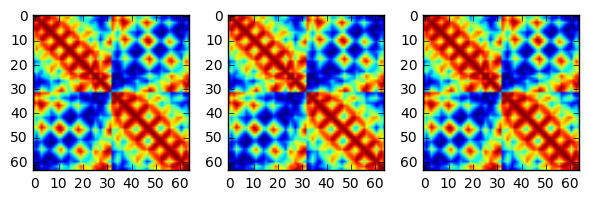

In [18]:
import numpy as np
from scipy.special import lpmn
from numpy.linalg import inv

%matplotlib inline

@np.vectorize
def vector_legendre(n, x):
    return lpmn(0, n, x)[0][-1, -1]
    
def compute_GH(x, y, z):
    
    num_electrodes = len(x)
    if num_electrodes > 100:
        m = 3
        leg_order = 40
    else:
        m = 4
        leg_order = 20
        
    x, y, z = unit_sphere(x, y, z)
    G = np.zeros((num_electrodes, num_electrodes))
    H = np.zeros((num_electrodes, num_electrodes))
    cos_dist = np.zeros((num_electrodes, num_electrodes))
    
    # Compute the Cosine Distance Between Electrodes
    for i in range(num_electrodes):
        for j in range(i+1, num_electrodes):
            cos_dist[i, j] = 1 - (((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2) / 2.)
            
    cos_dist = cos_dist + cos_dist.T + np.identity(num_electrodes)
    
    # Compute the Legendre Polynomials
    leg_poly = np.zeros((leg_order, num_electrodes, num_electrodes))
    for n in range(1, leg_order + 1):
        leg_poly[n-1, :, :] = vector_legendre(n, cos_dist)
    
    for i in range(num_electrodes):
        for j in range(i, num_electrodes):
            
            g = 0
            h = 0
            
            for n in range(1, leg_order+1):
                g += ((2*n + 1) * leg_poly[n-1, i, j]) / ((n * (n + 1))**m)
                h -= ((2*n + 1) * leg_poly[n-1, i, j]) / ((n * (n + 1))**(m - 1))
            
            G[i, j] = g / (4 * np.pi)
            H[i, j] = -h / (4 * np.pi)
            
    
    G += G.T
    H += H.T
    
    # ??
    G -= np.identity(num_electrodes) * G[0, 0] / 2.
    H -= np.identity(num_electrodes) * H[0, 0] / 2.
    
    return G, H, cos_dist

        
G, H, cd = compute_GH(x, y, z)

f, axs = plt.subplots(1, 3)
m1 = axs[0].imshow(G)
m2 = axs[1].imshow(H)

axs[2].imshow(cd)
plt.tight_layout()
plt.show()    

## Compute Surface Laplacian

In [21]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def laplacian(data, G, H, smoothing=1e-5):
    
    orig_shape = data.shape
    
    data = np.reshape(data, (orig_shape[0], orig_shape[1] * orig_shape[2]))
    
    num_electrodes, num_time_points = data.shape
    
    Gs = G + np.identity(num_electrodes) * smoothing
    
    Gi = inv(Gs)
    
    d = data.T.dot(Gi)
    
    C = d - (np.sum(d, axis=1)/np.sum(Gi))[:, np.newaxis].dot(np.sum(Gi, axis=1)[np.newaxis, :])
    
    surf_lap = C.dot(H.T).T

    surf_lap = np.reshape(surf_lap, orig_shape)
    return surf_lap

lap = laplacian(data, G, H)

## Generate Topomaps

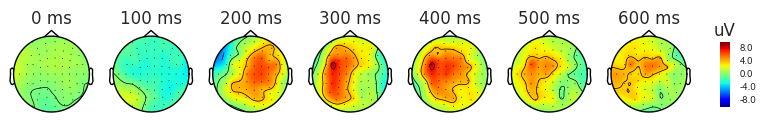

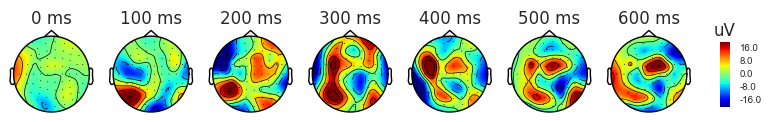

In [23]:
from mne.channels import Montage
from mne import EvokedArray, create_info

%matplotlib inline

ch_names = ['E' + str(i + 1) for i in range(data.shape[0])]
pos = np.vstack((x, y, z)).T
kind='sample'
indices = np.arange(data.shape[0])
montage = Montage(pos, ch_names, kind, indices)

info = create_info(ch_names, 256, ['eeg'] * data.shape[0] , montage)

data_m = data.mean(axis=-1).squeeze()
lap_m = lap.mean(axis=-1).squeeze()

evoked_array = EvokedArray(data_m/1e6, info, -1)
evoked_lap_array = EvokedArray(lap_m/1e6, info, -1)
evoked_array.plot_topomap(times=np.arange(0, .601, .100), vmin=-10, vmax=10, cmap='jet')
evoked_lap_array.plot_topomap(times=np.arange(0, .601, .100), vmin=-20, vmax=20, cmap='jet');

## Test equivalence of Python translation and Cohen code

In [47]:
from scipy.io import loadmat
from numpy.testing import assert_allclose
solution = loadmat('cohen_laplacian_output.mat')
data = solution['data']
lap_sol = solution['lap']
x, y, z = solution['x'].squeeze(), solution['y'].squeeze(), solution['z'].squeeze()
G_sol = solution['G']
H_sol = solution['H']


G, H, _ = compute_GH(x, y, z)
assert_allclose(G, G_sol)
assert_allclose(H, H_sol)

lap = laplacian(data, G, H)
assert_allclose(lap, lap_sol, atol=1e-0, rtol=0)

# Develop for MEG Bay Data

## Extract Coordinates

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', -1)
chs = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5',
       'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3',
       'FC1', 'FCz', 'FC2', 'FC4', 'FC6', "FT8", 'FT10', 'T9', 'T7', 'C5',
       'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'T10', 'TP9', 'TP7', 'CP5',
       'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P9', 'P7',
       'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3',
       'POz', 'PO4', 'PO8', 'O1', 'Oz', "O2", 'Iz']
print(len(chs))
data = pd.read_csv('plotting_1005.txt', sep='\t', header=None)
full_chs = np.array(data.loc[:, 0])
ch_ix = [ix for ix in np.arange(len(full_chs)) if full_chs[ix] in chs]
data = data.loc[ch_ix, :]
data.to_csv('meg_bay_coordinates.txt', header=False)
x = np.array(data.loc[:, 1]).squeeze()
y = np.array(data.loc[:, 2]).squeeze()
z = np.array(data.loc[:, 3]).squeeze()
# visualize_coordinates(x, y, z)

70


## Compute surface laplacian on sample data 

In [21]:
from mne import read_evokeds, combine_evoked
from mne_surface_laplacian import *
from ipywidgets import interact

%matplotlib inline

i_evo = read_evokeds('./group_Incongruent-ave.fif', verbose=False)[0]
c_evo = read_evokeds('./group_Congruent-ave.fif', verbose=False)[0]

i_evo_lap = surface_laplacian(i_evo, x, y, z)
c_evo_lap = surface_laplacian(c_evo, x, y, z)

def plot_stim_topomaps(time):
    
    conditions = ["Incongruent", "Congruent"]

    conflict_evoked = combine_evoked([i_evo, c_evo], [1, -1])
    
    (f, axs) = plt.subplots(2, 3, figsize=(12, 6))
    
    i_evo.plot_topomap(times = time, show=False, axes=axs[0,0], colorbar=False)
    c_evo.plot_topomap(times = time, show=False, axes=axs[0,1], colorbar=False)
    conflict_evoked.plot_topomap(times = time, show=False, axes=axs[0,2], colorbar=False) 
    
    axs[0,0].set_xlabel("Incongruent")
    axs[0,1].set_xlabel("Congruent")
    axs[0,2].set_xlabel("I-C")
    
    conflict_evoked_lap = combine_evoked([i_evo_lap, c_evo_lap], [1, -1])
    
    i_evo_lap.plot_topomap(times = time, show=False, axes=axs[1,0], colorbar=False, vmin=-15, vmax=15)
    c_evo_lap.plot_topomap(times = time, show=False, axes=axs[1,1], colorbar=False, vmin=-15, vmax=15)
    conflict_evoked_lap.plot_topomap(times = time, show=False, axes=axs[1,2], colorbar=False) 
    
    axs[1,0].set_xlabel("Laplacian Incongruent")
    axs[1,1].set_xlabel("Laplacian Congruent")
    axs[1,2].set_xlabel("Laplacian I-C")
    plt.show()
    
interact(plot_stim_topomaps, time = (-.5, 1.75, .05));

# Visualizations for Intuition